In [1]:
# All imports
import pandas as pd
from category_encoders import OneHotEncoder, OrdinalEncoder
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import permutations
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import roc_auc_score, roc_curve, plot_confusion_matrix, plot_roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
random_state = 1

In [2]:
df = pd.read_csv('diabetic_data.csv', na_values=['?'])
df

encounter_id  patient_nbr             race  gender      age weight  \
0            2278392      8222157        Caucasian  Female   [0-10)    NaN   
1             149190     55629189        Caucasian  Female  [10-20)    NaN   
2              64410     86047875  AfricanAmerican  Female  [20-30)    NaN   
3             500364     82442376        Caucasian    Male  [30-40)    NaN   
4              16680     42519267        Caucasian    Male  [40-50)    NaN   
...              ...          ...              ...     ...      ...    ...   
101761     443847548    100162476  AfricanAmerican    Male  [70-80)    NaN   
101762     443847782     74694222  AfricanAmerican  Female  [80-90)    NaN   
101763     443854148     41088789        Caucasian    Male  [70-80)    NaN   
101764     443857166     31693671        Caucasian  Female  [80-90)    NaN   
101765     443867222    175429310        Caucasian    Male  [70-80)    NaN   

        admission_type_id  discharge_disposition_id  admission_source_id  \
0                       6                        25                    1   
1                       1                         1                    7   
2                       1                         1                    7   
3                       1                         1                    7   
4                       1                         1                    7   
...                   ...                       ...                  ...   
101761                  1                         3                    7   
101762                  1                         4                    5   
101763                  1                         1                    7   
101764                  2                         3                    7   
101765                  1                         1                    7   

        time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                      1  ...          No      No                   No   
1                      3  ...          No      Up                   No   
2                      2  ...          No      No                   No   
3                      2  ...          No      Up                   No   
4                      1  ...          No  Steady                   No   
...                  ...  ...         ...     ...                  ...   
101761                 3  ...          No    Down                   No   
101762                 5  ...          No  Steady                   No   
101763                 1  ...          No    Down                   No   
101764                10  ...          No      Up                   No   
101765                 6  ...          No      No                   No   

        glipizide-metformin  glimepiride-pioglitazone  \
0                        No                        No   
1                        No                        No   
2                        No                        No   
3                        No                        No   
4                        No                        No   
...                     ...                       ...   
101761                   No                        No   
101762                   No                        No   
101763                   No                        No   
101764                   No                        No   
101765                   No                        No   

        metformin-rosiglitazone  metformin-pioglitazone  change diabetesMed  \
0                            No                      No      No          No   
1                            No                      No      Ch         Yes   
2                            No                      No      No         Yes   
3                            No                      No      Ch         Yes   
4                            No                      No      Ch         Yes   
...                         ...                     ...     ...         ...   
101761                       No

## Part A: Feature engineering, supervised learning and evaluation of results

Let's look at the features in the dataset referring to their descriptions in the paper, we'll decide if any transformations need to be done.

In [3]:
ordered_mapping = lambda x : {v: i for i, v in enumerate(x)}
categorical_mappings = []
onehot_columns = []

### Encounter Id (encounter_id)

Unique identifier of an encounter

We will drop this column as it does not give us any actual qualitative information

In [4]:
df.drop('encounter_id', axis=1, inplace=True)

### Patient number (patient_nbr)

Unique identifier of a patient

We will drop this column as it does not give us any actual qualitative information

In [5]:
df.drop('patient_nbr', axis=1, inplace=True)

### Race (race)

Values: Caucasian, Asian, African American, Hispanic, and other

This is a categorical variable without ordering. There appear to be 2% missing values, we will assign them to an Unknown category.

In [6]:
onehot_columns.append('race')
df['race'].fillna('Unknown', inplace=True)
df['race'].value_counts(dropna=False)

Caucasian          76099
AfricanAmerican    19210
Unknown             2273
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64

#### Gender (gender)

Values, Male/Female, Unknown/Invalid

We will encode this variable in a -1, 0, 1 fashion


In [7]:
categorical_mappings.append({
    "col": "gender",
    "mapping": {
        "Male": 1,
        "Female": -1,
        "Unknown/Invalid": 0,
    }
})
df['gender'].value_counts()

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

### Age (age)

This is an ordinal variable, we will order them accoridng to the age ranges.

In [8]:
categorical_mappings.append({
    "col": "age",
    "mapping": ordered_mapping([f"[{i}-{i+10})" for i in range(0, 100, 10)]),
})
df['age'].value_counts()

[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: age, dtype: int64

### Weight (weight)

There look to be 98% missing values according to the paper. Let's verify and drop the column if this is the case

In [9]:
df['weight'].value_counts(dropna=False)

NaN          98569
[75-100)      1336
[50-75)        897
[100-125)      625
[125-150)      145
[25-50)         97
[0-25)          48
[150-175)       35
[175-200)       11
>200             3
Name: weight, dtype: int64

Because of this disproportionality we will drop the column

In [10]:
df.drop('weight', axis=1, inplace=True)

### Admission type (admission_type_id)

Integer identifier corresponding to 9 distinct values, for example, emergency, urgent, elective, newborn, and not available

There is no obvious ordering for these so for this reason we will need to encode this as a categorical variable using one-hot encoding.

We note that categories "NULL", "not available" and "not mapped" are all effectively unknown and we therefore combine them into one category.

In [11]:
onehot_columns.append('admission_type_id')
df.replace([6, 8], 5, inplace=True)
df['admission_type_id'].value_counts(dropna=False)

1    53990
3    18869
2    18480
5    10396
7       21
4       10
Name: admission_type_id, dtype: int64

### Discharge disposition (discharge_disposition_id)

Integer identifier corresponding to 29 distinct values, for example, discharged to home, expired, and not available.

There is no obvious ordering for these so for this reason we will need to encode this as a categorical variable using one-hot encoding.

We note that categories "NULL", "not available" and "not mapped" are all effectively unknown and we therefore combine them into one category.There does not appear to be an ordinal 

In [12]:
onehot_columns.append('discharge_disposition_id')
df['discharge_disposition_id'].replace([25, 26], 18, inplace=True)
df['discharge_disposition_id'].value_counts(dropna=False)

1     60234
5     14194
3     13954
18     4680
2      2128
22     1993
11     1642
4       815
7       623
23      412
13      399
14      372
28      139
15       63
24       48
9        21
17       14
16       11
19        8
10        6
27        5
12        3
20        2
Name: discharge_disposition_id, dtype: int64

### Admission source (admission_source_id)

Integer identifier corresponding to 21 distinct values, for example, physician referral, emergency room, and transfer from a hospital

There is no obvious ordering for these so for this reason we will need to encode this as a categorical variable using one-hot encoding.

We note that categories "NULL", "not available" and "not mapped" are all effectively unknown and we therefore combine them into one category.There does not appear to be an ordinal 

In [13]:
onehot_columns.append('admission_source_id')
df['admission_source_id'].replace([17, 21], 15)
df['admission_source_id'].value_counts(dropna=False)

7     57494
1     29565
17     6781
4      3187
5      3135
2      1104
3       187
20      161
9       125
22       12
10        8
25        2
14        2
11        2
13        1
Name: admission_source_id, dtype: int64

### Time in hospital (time_in_hospital)

Integer number of days between admission and discharge

In [14]:
df['time_in_hospital'].describe()

count    101766.000000
mean          4.192461
std           2.856774
min           1.000000
25%           2.000000
50%           4.000000
75%           5.000000
max          14.000000
Name: time_in_hospital, dtype: float64

### Payer code (payer_code)

Two letter identifier corresponding to 23 distinct values, for example, Blue Cross\Blue Shield, Medicare, and self-pay

This is categorical and not ordinal so it will be one-hot encoded.

Note there are 53% unknowns here

In [15]:
onehot_columns.append('payer_code')
df['payer_code'].fillna('Unknown', inplace=True)
df['payer_code'].value_counts(dropna=False)

Unknown    40256
MC         32439
HM          6274
SP          5007
BC          4655
MD          3532
CP          2533
UN          2448
CM          1937
OG          1033
PO           592
DM           549
CH           146
WC           135
OT            95
MP            79
SI            55
FR             1
Name: payer_code, dtype: int64

### Medical speciality (medical_specialty)

Integer identifier of a specialty of the admitting physician, corresponding to 84 distinct values, for example, cardiology, internal medicine, family\general practice, and surgeon

This is categorical and not ordinal so it will be one-hot encoded.

Note 53% of values are unknown here.


In [16]:
onehot_columns.append('medical_specialty')
df['medical_specialty'].fillna('Unknown', inplace=True)
df['medical_specialty'].value_counts(dropna=False)

Unknown                             49949
InternalMedicine                    14635
Emergency/Trauma                     7565
Family/GeneralPractice               7440
Cardiology                           5352
                                    ...  
Perinatology                            1
Dermatology                             1
Proctology                              1
Surgery-PlasticwithinHeadandNeck        1
Speech                                  1
Name: medical_specialty, Length: 73, dtype: int64

### Number of lab procedures (num_lab_procedures)

Number of tests performed during the encounter

In [17]:
df['num_lab_procedures'].describe()

count    101766.000000
mean         43.082080
std          19.699706
min           1.000000
25%          31.000000
50%          44.000000
75%          57.000000
max         132.000000
Name: num_lab_procedures, dtype: float64

### Number of procedures (num_procedures)

Number of procedures (other than lab tests) performed during the encounter

In [18]:
df['num_procedures'].describe()

count    101766.000000
mean          1.291050
std           1.581884
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max           5.000000
Name: num_procedures, dtype: float64

### Number of medications (num_medications)

Number of distinct generic names administered during the encounter

In [19]:
df['num_medications'].describe()

count    101766.000000
mean         15.866999
std           8.308746
min           1.000000
25%          10.000000
50%          15.000000
75%          20.000000
max          81.000000
Name: num_medications, dtype: float64

### Number of outpatient visits (number_outpatient)

Number of outpatient visits of the patient in the year preceding the encounter

In [20]:
df['number_outpatient'].describe()

count    101766.000000
mean          0.363491
std           1.240948
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          42.000000
Name: number_outpatient, dtype: float64

### Number of emergency visits (number_emergency)

Number of emergency visits of the patient in the year preceding the encounter

In [21]:
df['number_emergency'].describe()

count    101766.000000
mean          0.195439
std           0.915095
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          76.000000
Name: number_emergency, dtype: float64

### Number of inpatient visits (number_inpatient)

Number of inpatient visits of the patient in the year preceding the encounter

In [22]:
df['number_inpatient'].describe()

count    101766.000000
mean          0.626398
std           1.223373
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          21.000000
Name: number_inpatient, dtype: float64

### Diagnoses

The next three categories contain nearly a thousand distrinct values each. To reduce dimensionality we will categorize the diagnosis codes into categories according to page 5 of the paper. We note that codes 783 and 789 aren't covered and slot those into the Unknown category.

In [23]:
def categorize_diagnosis(diag):
    diag = str(diag)
    if diag == 'Unknown':
        return 'Unknown'
    elif diag.startswith('E') or diag.startswith('V'):
        return 'External'
    diag = int(float(diag))
    if diag == 250:
        return 'Diabetes'
    elif (diag >= 390 and diag <= 459) or diag == 785:
        return 'Circulatory'
    elif (diag >= 460 and diag <= 519) or diag == 786:
        return 'Respiratory'
    elif (diag >= 520 and diag <= 579) or diag == 787:
        return 'Digestive'
    elif diag >= 800 and diag <= 999:
        return 'Injury'
    elif diag >= 710 and diag <= 739:
        return 'Musculoskeletal'
    elif (diag >= 580 and diag <= 629) or diag == 788:
        return 'Genitourinary'
    elif diag >= 140 and diag <= 239:
        return 'Neoplasms'
    elif diag == 780 or diag == 781 or diag == 784 or (diag >= 790 and diag <= 799):
        return 'Other'
    elif (diag >= 240 and diag <= 279) and diag != 250:
        return 'Endocrine'
    elif (diag >= 680 and diag <= 709) or diag == 782:
        return 'Skin'
    elif diag >= 1 and diag <= 139:
        return 'Infectious'
    elif diag >= 290 and diag <= 319:
        return 'Mental'
    elif diag >= 280 and diag <= 289:
        return 'Blood'
    elif diag >= 320 and diag <= 359:
        return 'Nervous'
    elif diag >= 630 and diag <= 679:
        return 'Pregnancy'
    elif diag >= 360 and diag <= 389:
        return 'Sense'
    elif diag >= 740 and diag <= 759:
        return 'Congenital'
    else:
        return 'Unknown'

### Diagnosis 1 (diag_1)

The primary diagnosis (coded as first three digits of ICD9); 848 distinct values

In [24]:
onehot_columns.append('diag_1')
df['diag_1'].fillna('Unknown', inplace=True)
df['diag_1'] = df['diag_1'].apply(categorize_diagnosis)
df['diag_1'].value_counts()

Circulatory        30437
Respiratory        14423
Digestive           9475
Diabetes            8757
Injury              6974
Genitourinary       5117
Musculoskeletal     4957
Neoplasms           3433
Infectious          2768
Endocrine           2702
Skin                2614
Other               2539
Mental              2262
External            1645
Blood               1103
Nervous              947
Pregnancy            687
Unknown              611
Sense                264
Congenital            51
Name: diag_1, dtype: int64

### Diagnosis 2 (diag_2)

Secondary diagnosis (coded as first three digits of ICD9); 923 distinct values

In [25]:
onehot_columns.append('diag_2')
df['diag_2'].fillna('Unknown', inplace=True)
df['diag_2'] = df['diag_2'].apply(categorize_diagnosis)
df['diag_2'].value_counts()

Circulatory        31881
Diabetes           12794
Respiratory        10895
Genitourinary       8376
Endocrine           8223
Digestive           4170
Skin                3670
Blood               2926
Mental              2657
Neoplasms           2547
External            2536
Other               2434
Injury              2428
Infectious          1931
Musculoskeletal     1764
Nervous             1126
Unknown              725
Pregnancy            415
Sense                160
Congenital           108
Name: diag_2, dtype: int64

### Diagnosis 3 (diag_3)

Additional secondary diagnosis (coded as first three digits of ICD9); 954 distinct values

In [26]:
onehot_columns.append('diag_3')
df['diag_3'].fillna('Unknown', inplace=True)
df['diag_3'] = df['diag_3'].apply(categorize_diagnosis)
df['diag_3'].value_counts()

Circulatory        30306
Diabetes           17157
Endocrine           9151
Respiratory         7358
Genitourinary       6680
External            5058
Digestive           3930
Mental              3136
Skin                2607
Blood               2490
Other               2374
Injury              1946
Musculoskeletal     1915
Infectious          1861
Neoplasms           1856
Unknown             1770
Nervous             1503
Pregnancy            309
Sense                263
Congenital            96
Name: diag_3, dtype: int64

### Number of diagnoses (number_diagnoses)

Number of diagnoses entered to the system

In [27]:
df['number_diagnoses'].describe()

count    101766.000000
mean          7.009807
std           2.128335
min           1.000000
25%           5.000000
50%           7.000000
75%           9.000000
max          16.000000
Name: number_diagnoses, dtype: float64

### Glucose serum test result (max_glu_serum)

Indicates the range of the result or if the test was not taken. Values: “>200,” “>300,” “normal,” and “none” if not measured.

These are ordinal, and we will make the assumption that None, Norm, >200, >300 is a sensible one.

In [28]:
categorical_mappings.append({
    'col': 'max_glu_serum',
    'mapping': ordered_mapping(('None', 'Norm', '>200', '>300')),
})
df['max_glu_serum'].value_counts()

None    96420
Norm     2597
>200     1485
>300     1264
Name: max_glu_serum, dtype: int64

### A1c test result (A1Cresult)

Indicates the range of the result or if the test was not taken. Values: “>8” if the result was greater than 8%, “>7” if the result was greater than 7% but less than 8%, “normal” if the result was less than 7%, and “none” if not measured.

The values are ordinal and we will assume None, Norm, >7, >8

In [29]:
categorical_mappings.append({
    'col': 'A1Cresult',
    'mapping': ordered_mapping(('None', 'Norm', '>7', '>8')),
})
df['A1Cresult'].value_counts()

None    84748
>8       8216
Norm     4990
>7       3812
Name: A1Cresult, dtype: int64

### Change of medications (change)

Indicates if there was a change in diabetic medications (either dosage or generic name). Values: “change” and “no change”

No change will be -1, and change will be 1.

In [30]:
categorical_mappings.append({
    'col': 'change',
    'mapping': {
        'No': -1,
        'Ch': 1,
    },
})
df['change'].value_counts()

No    54755
Ch    47011
Name: change, dtype: int64

### Diabetes medications (diabetesMed)

Indicates if there was any diabetic medication prescribed. Values: “yes” and “no”.

Yes will be 1 and No will be -1

In [31]:
categorical_mappings.append({
    'col': 'diabetesMed',
    'mapping': {
        'No': -1,
        'Yes': 1,
    },
})
df['diabetesMed'].value_counts()

Yes    78363
No     23403
Name: diabetesMed, dtype: int64

### Readmitted (readmitted)

Days to inpatient readmission. Values: “<30” if the patient was readmitted in less than 30 days, “>30” if the patient was readmitted in more than 30 days, and “No” for no record of readmission.

We assume an order of NO, <30 and >30.

In [32]:
categorical_mappings.append({
    'col': 'readmitted',
    'mapping': ordered_mapping(('NO', '<30', '>30')),
})
df['readmitted'].value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

### 24 features for medications

Values: “up” if the dosage was increased during the encounter, “down” if the dosage was decreased, “steady” if the dosage did not change, and “no” if the drug was not prescribed

We assume an order of No, Down, Steady and Up

In [33]:
medications = [
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
]
for medication in medications:
    categorical_mappings.append({
        'col': medication,
        'mapping': ordered_mapping(['No', 'Down', 'Steady', 'Up']),
    })
    print(df[medication].value_counts())

No        81778
Steady    18346
Up         1067
Down        575
Name: metformin, dtype: int64
No        100227
Steady      1384
Up           110
Down          45
Name: repaglinide, dtype: int64
No        101063
Steady       668
Up            24
Down          11
Name: nateglinide, dtype: int64
No        101680
Steady        79
Up             6
Down           1
Name: chlorpropamide, dtype: int64
No        96575
Steady     4670
Up          327
Down        194
Name: glimepiride, dtype: int64
No        101765
Steady         1
Name: acetohexamide, dtype: int64
No        89080
Steady    11356
Up          770
Down        560
Name: glipizide, dtype: int64
No        91116
Steady     9274
Up          812
Down        564
Name: glyburide, dtype: int64
No        101743
Steady        23
Name: tolbutamide, dtype: int64
No        94438
Steady     6976
Up          234
Down        118
Name: pioglitazone, dtype: int64
No        95401
Steady     6100
Up          178
Down         87
Name: rosiglitazone, dty

In [34]:
df = OneHotEncoder(cols=onehot_columns, use_cat_names=True).fit_transform(OrdinalEncoder(cols=[c['col'] for c in categorical_mappings], mapping=categorical_mappings).fit_transform(df))

## Task 1

We will train decision tree, naive bais and knn classifiers as these support multiclass natively. We'll also investigate boosting.

In [35]:

split_col = lambda d, c : (d[d.columns.difference([c])], d[c])

def cv_roc(classifier, X, y, ys=None, show=True):
    # Adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
    if ys is None:
        ys = y
    cv = KFold(n_splits=10)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots()

    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X.iloc[train], ys.iloc[train])
        viz = plot_roc_curve(classifier, X.iloc[test], y.iloc[test],
                            name='ROC fold {}'.format(i),
                            alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
        title=f"Receiver operating characteristic for {classifier.__class__.__name__}")
    ax.legend(loc="lower right")
    if show:
        plt.show()
    return mean_auc

def analyse_cm(cm, pr=True):
    # We will analyse accuracy in terms of negative class (0) vs rest
    r = range(1, len(cm))
    tp = sum(cm[a][b] for a,b in list(permutations(r, r=2)) + list(zip(r, r)))
    fp = sum(cm[0][i] for i in r)
    tn = cm[0][0]
    fn = sum(cm[i][0] for i in r)
    recall = tpr = tp / (tp + fn)
    specificity = tnr = tn / (tn + fp)
    precision = ppv = tp / (tp + fp)
    F = 2 * ((precision * recall) / (precision + recall))
    c = {
        "recall": recall,
        "specificity": specificity,
        "precision": precision,
        "F": F,
    }
    if pr:
        for k in c:
            print(f"{k}: {c[k]}")
    return c

##### Decision Tree Classifier

In [36]:
clf = DecisionTreeClassifier(random_state=random_state)

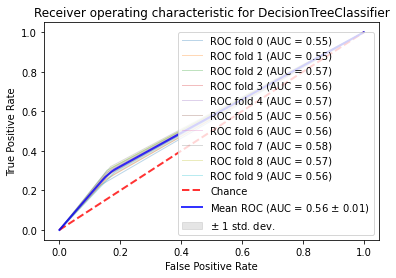

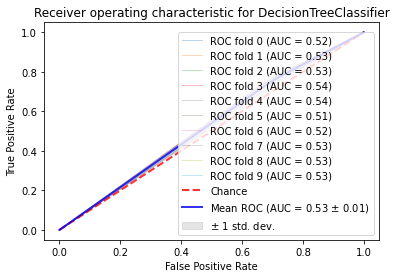

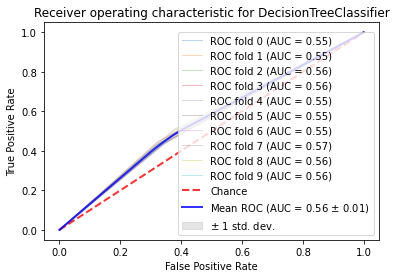

Mean auc score: 0.549


In [37]:
auc_buffer = 0
for pair in ((0, 1), (1, 2), (0, 2)):
    X, y = split_col(df[df["readmitted"].isin(pair)], "readmitted")
    auc_buffer += cv_roc(clf, X, y)
m_auc1 = round(auc_buffer / 3, 3)
print(f"Mean auc score: {m_auc1}")

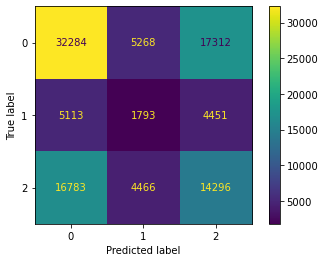

In [38]:
X, y = split_col(df, "readmitted")
score1 = cross_val_score(clf, X, y, cv=10)
cm = confusion_matrix(y, cross_val_predict(clf, X, y, cv=10))
ConfusionMatrixDisplay(cm).plot()

In [39]:
cm1 = analyse_cm(cm)

recall: 0.5331542364931133
specificity: 0.5884368620589093
precision: 0.5254906905392343
F: 0.5292947252561173


##### Naive Bais

In [40]:
clf = BernoulliNB()

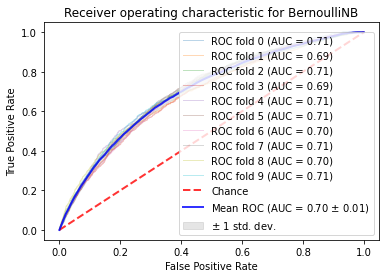

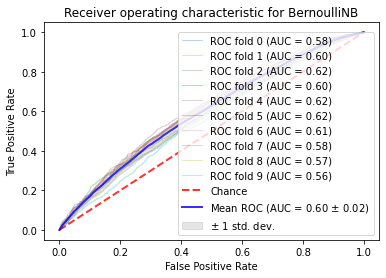

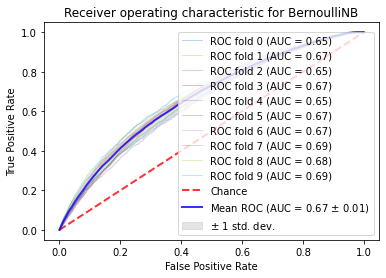

Mean auc score: 0.657


In [41]:
auc_buffer = 0
for pair in ((0, 1), (1, 2), (0, 2)):
    X, y = split_col(df[df["readmitted"].isin(pair)], "readmitted")
    auc_buffer += cv_roc(clf, X, y)
m_auc2 = round(auc_buffer / 3, 3)
print(f"Mean auc score: {m_auc2}")

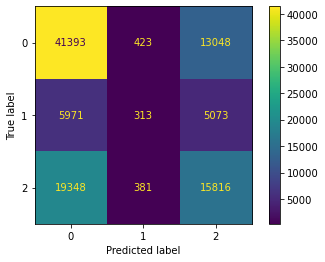

In [42]:
X, y = split_col(df, "readmitted")
score2 = cross_val_score(clf, X, y, cv=10)
cm = confusion_matrix(y, cross_val_predict(clf, X, y, cv=10))
ConfusionMatrixDisplay(cm).plot()

In [43]:
cm2 = analyse_cm(cm)

recall: 0.46017227410344974
specificity: 0.7544655876348789
precision: 0.6157071946140241
F: 0.5266972521840988


##### K Nearest Neighbours

Let's first approximate the best value for k

Min i is 39 with mean error of 0.4435491795224526


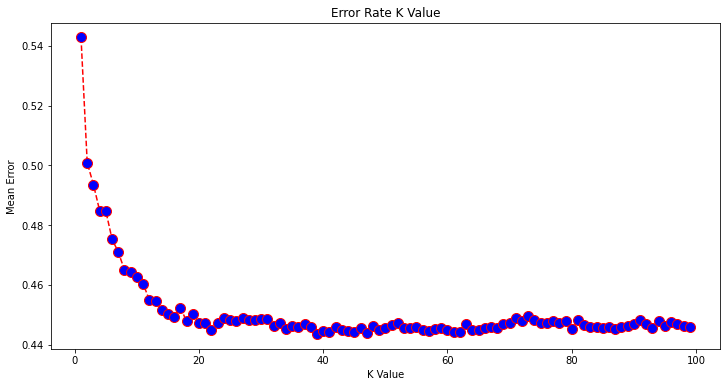

In [44]:
X_train, X_test, y_train, y_test = train_test_split(*split_col(df, "readmitted"), test_size=0.1, random_state=random_state)
error = []

# Calculating error for K values between 1 and 100
min_i = None
min_error = None
samples = 100
for i in range(1, samples):
    clf_knn = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    clf_knn.fit(X_train, y_train)
    pred_i = clf_knn.predict(X_test)
    mean_error = np.mean(pred_i != y_test)
    if (not min_i and not min_error) or (mean_error < min_error):
        min_i = i
        min_error = mean_error
    error.append(mean_error)
print(f"Min i is {min_i} with mean error of {min_error}")
plt.figure(figsize=(12, 6))
plt.plot(range(1, samples), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')
plt.show()


In [45]:
clf = KNeighborsClassifier(n_neighbors=min_i, n_jobs=-1)

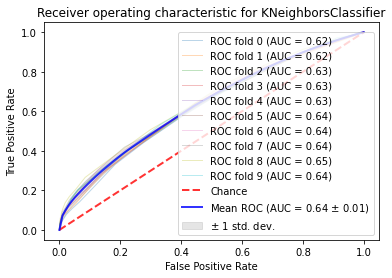

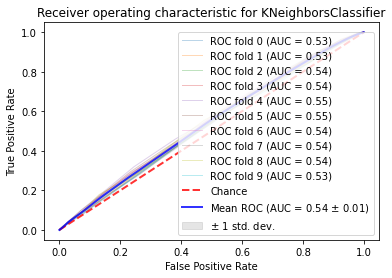

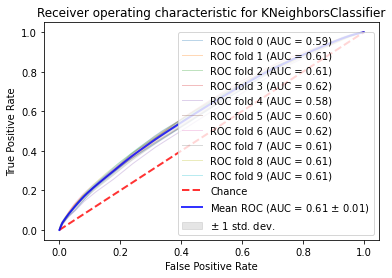

Mean auc score: 0.593


In [46]:
auc_buffer = 0
for pair in ((0, 1), (1, 2), (0, 2)):
    X, y = split_col(df[df["readmitted"].isin(pair)], "readmitted")
    auc_buffer += cv_roc(clf, X, y)
m_auc3 = round(auc_buffer / 3, 3)
print(f"Mean auc score: {m_auc3}")

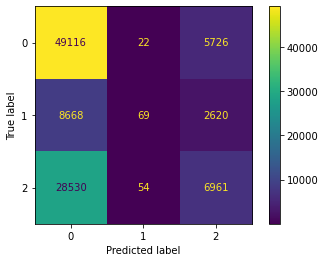

In [47]:
X, y = split_col(df, "readmitted")
score3 = cross_val_score(clf, X, y, cv=10)
cm = confusion_matrix(y, cross_val_predict(clf, X, y, cv=10))
ConfusionMatrixDisplay(cm).plot()

In [48]:
cm3 = analyse_cm(cm)

recall: 0.2068994925589527
specificity: 0.8952318460192475
precision: 0.6280093191819829
F: 0.31125509189466594


##### Analysis



In [49]:
from scipy.stats import ttest_rel
_, pval1 = ttest_rel(score1, score2)
_, pval2 = ttest_rel(score1, score3)
_, pval3 = ttest_rel(score2, score3)
score_diff1 = score1 - score2
score_diff2 = score1 - score3
score_diff3 = score2 - score3
print(f"Fold\tDT-NB\tDT-KN\tNB-KN")
for a, b, c, d in zip(
    list(range(1, 10 + 1)) + ["mean", 'stddev'],
    list(score_diff1) + [score_diff1.mean(), score_diff1.std()],
    list(score_diff2) + [score_diff2.mean(), score_diff2.std()],
    list(score_diff3) + [score_diff3.mean(), score_diff3.std()],
    ):
    print(f"{a}\t{round(b, 3)}\t{round(c, 3)}\t{round(d, 3)}")
print(f"p-value\t{round(pval1, 3)}\t{round(pval2, 12)}\t{round(pval3, 12)}")

Fold	DT-NB	DT-KN	NB-KN
1	-0.084	-0.067	0.017
2	-0.089	-0.069	0.02
3	-0.075	-0.061	0.014
4	-0.087	-0.081	0.006
5	-0.082	-0.07	0.012
6	-0.1	-0.082	0.018
7	-0.096	-0.085	0.011
8	-0.092	-0.088	0.004
9	-0.094	-0.077	0.018
10	-0.1	-0.085	0.015
mean	-0.09	-0.076	0.014
stddev	0.008	0.009	0.005
p-value	0.0	7.67e-10	1.7170988e-05


Because of the extemely small p-value, we can confidently say these algorithms are significantly different.

NB apears to perform best

In [50]:
print("Algorithm\tRecall\tSpecificity\tPrecision\tF\tm auc")
for cm, m_auc, alg in zip([cm1, cm2, cm3], [m_auc1, m_auc2, m_auc3], ["DT", "NB", "KN"]):
    print(f"{alg}\t{round(cm['recall'], 6)}\t{round(cm['specificity'], 6)}\t{round(cm['precision'], 6)}\t{round(cm['F'], 3)}\t{round(m_auc, 3)}")

Algorithm	Recall	Specificity	Precision	F	m auc
DT	0.533154	0.588437	0.525491	0.529	0.549
NB	0.460172	0.754466	0.615707	0.527	0.657
KN	0.206899	0.895232	0.628009	0.311	0.593


Results are pretty mediocre, let's see if we can do better with boosting.

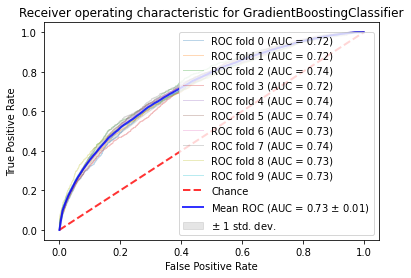

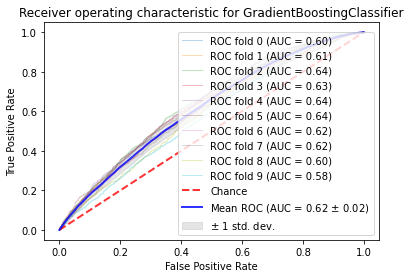

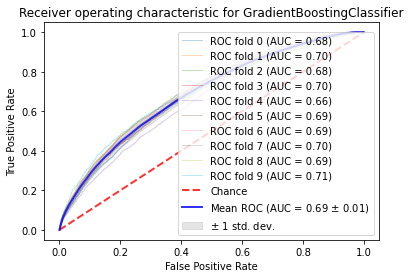

Mean auc score: 0.679


In [51]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=random_state)
auc_buffer = 0
for pair in ((0, 1), (1, 2), (0, 2)):
    X, y = split_col(df[df["readmitted"].isin(pair)], "readmitted")
    auc_buffer += cv_roc(clf, X, y)
m_auc4 = round(auc_buffer / 3, 3)
print(f"Mean auc score: {m_auc4}")

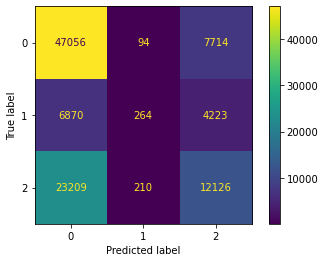

In [52]:
X, y = split_col(df, "readmitted")
score2 = cross_val_score(clf, X, y, cv=10)
cm = confusion_matrix(y, cross_val_predict(clf, X, y, cv=10))
ConfusionMatrixDisplay(cm).plot()

In [53]:
cm4 = analyse_cm(cm)

recall: 0.3586840646454309
specificity: 0.8576844561096529
precision: 0.683001096179611
F: 0.47035633903233476


In [54]:
print("Algorithm\tRecall\tSpecificity\tPrecision\tF\tm auc")
for cm, m_auc, alg in zip([cm1, cm2, cm3, cm4], [m_auc1, m_auc2, m_auc3, m_auc4], ["DT", "NB", "KN", "BO"]):
    print(f"{alg}\t{round(cm['recall'], 6)}\t{round(cm['specificity'], 6)}\t{round(cm['precision'], 6)}\t{round(cm['F'], 3)}\t{round(m_auc, 3)}")

Algorithm	Recall	Specificity	Precision	F	m auc
DT	0.533154	0.588437	0.525491	0.529	0.549
NB	0.460172	0.754466	0.615707	0.527	0.657
KN	0.206899	0.895232	0.628009	0.311	0.593
BO	0.358684	0.857684	0.683001	0.47	0.679


### Task 2

We're interested to see if we can predict whether a certain medication was administered. Specifically insulin.

We'll use 3 models to round out the different families we have yet to explore: SVC, knn and random forest


In [55]:

X, y = split_col(df, "insulin")
# Turn it into a binary classifier
y.replace([2, 3], 1, inplace=True)
y.value_counts()

1    54383
0    47383
Name: insulin, dtype: int64

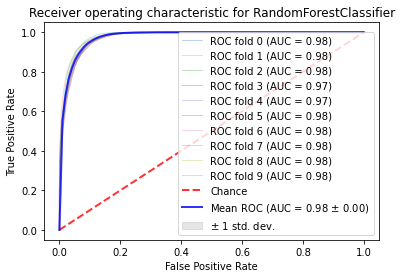

0.9757790861477218

In [56]:
clf = RandomForestClassifier(random_state=random_state)
cv_roc(clf, X, y)

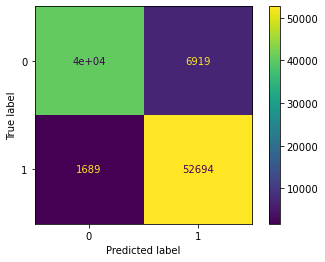

In [57]:
score1 = cross_val_score(clf, X, y, cv=10)
cm = confusion_matrix(y, cross_val_predict(clf, X, y, cv=10))
ConfusionMatrixDisplay(cm).plot()

In [58]:
analyse_cm(cm)

recall: 0.9689425004137322
specificity: 0.8539771648059431
precision: 0.8839347122271988
F: 0.9244885785466156


{'recall': 0.9689425004137322,
 'specificity': 0.8539771648059431,
 'precision': 0.8839347122271988,
 'F': 0.9244885785466156}

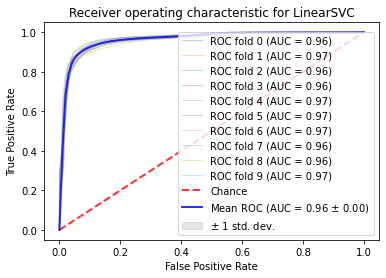

0.9633163475537243

In [59]:
clf = LinearSVC(random_state=random_state)
cv_roc(clf, X, y)

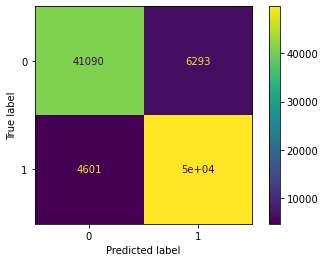

In [60]:
score2 = cross_val_score(clf, X, y, cv=10)
cm = confusion_matrix(y, cross_val_predict(clf, X, y, cv=10))
ConfusionMatrixDisplay(cm).plot()

In [61]:
analyse_cm(cm)

recall: 0.9153963554787342
specificity: 0.8671886541586645
precision: 0.8877753009362461
F: 0.90137427800612


{'recall': 0.9153963554787342,
 'specificity': 0.8671886541586645,
 'precision': 0.8877753009362461,
 'F': 0.90137427800612}

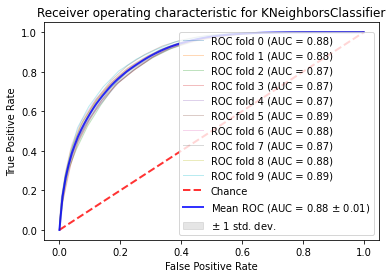

0.8775434087215449

In [62]:
clf = KNeighborsClassifier(n_neighbors=20)
cv_roc(clf, X, y)

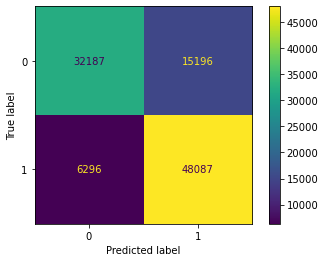

In [63]:
score3 = cross_val_score(clf, X, y, cv=10)
cm = confusion_matrix(y, cross_val_predict(clf, X, y, cv=10))
ConfusionMatrixDisplay(cm).plot()

In [64]:
analyse_cm(cm)

recall: 0.8842285272971333
specificity: 0.6792942616550239
precision: 0.759872319580298
F: 0.8173474070674621


{'recall': 0.8842285272971333,
 'specificity': 0.6792942616550239,
 'precision': 0.759872319580298,
 'F': 0.8173474070674621}

#### Analysis

In [65]:
from scipy.stats import ttest_rel
_, pval1 = ttest_rel(score1, score2)
_, pval2 = ttest_rel(score1, score3)
_, pval3 = ttest_rel(score2, score3)
score_diff1 = score1 - score2
score_diff2 = score1 - score3
score_diff3 = score2 - score3
print(f"Fold\tRF-SV\tRF-KN\tSV-KN")
for a, b, c, d in zip(
    list(range(1, 10 + 1)) + ["mean", 'stddev'],
    list(score_diff1) + [score_diff1.mean(), score_diff1.std()],
    list(score_diff2) + [score_diff2.mean(), score_diff2.std()],
    list(score_diff3) + [score_diff3.mean(), score_diff3.std()],
    ):
    print(f"{a}\t{round(b, 3)}\t{round(c, 3)}\t{round(d, 3)}")
print(f"p-value\t{round(pval1, 3)}\t{round(pval2, 12)}\t{round(pval3, 12)}")

Fold	RF-SV	RF-KN	SV-KN
1	-0.01	0.125	0.134
2	0.001	0.128	0.126
3	0.014	0.137	0.124
4	0.016	0.134	0.118
5	0.072	0.118	0.045
6	-0.003	0.115	0.117
7	0.001	0.125	0.125
8	0.022	0.127	0.104
9	0.106	0.131	0.024
10	0.005	0.127	0.123
mean	0.022	0.127	0.104
stddev	0.035	0.007	0.036
p-value	0.089	1e-12	1.0822114e-05


It appears that RF and SV are not statistically different, with KNN being different.

## Part B : Semi-supervised learning & evaluation of results

In [66]:
from sklearn.semi_supervised import LabelPropagation
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from pprint import pprint

In [67]:
def cv_roc(classifier, X, y, ys=None, show=True):
    # Adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
    if ys is None:
        ys = y
    cv = KFold(n_splits=10)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots()

    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X.iloc[train], ys.iloc[train])
        viz = plot_roc_curve(classifier, X.iloc[test], y.iloc[test],
                            name='ROC fold {}'.format(i),
                            alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
        title=f"Receiver operating characteristic for {classifier.__class__.__name__}")
    ax.legend(loc="lower right")
    if show:
        plt.show()
    return mean_auc

def analyse_cm(cm):
    # We will analyse accuracy in terms of negative class (0) vs rest
    r = range(1, len(cm))
    tp = sum(cm[a][b] for a,b in list(permutations(r, r=2)) + list(zip(r, r)))
    fp = sum(cm[0][i] for i in r)
    tn = cm[0][0]
    fn = sum(cm[i][0] for i in r)
    recall = tpr = tp / (tp + fn)
    specificity = tnr = tn / (tn + fp)
    precision = ppv = tp / (tp + fp)
    F = 2 * ((precision * recall) / (precision + recall))
    return {
        "recall": recall,
        "specificity": specificity,
        "precision": precision,
        "F": F,
    }

def sample_cm(clf, df, col, frac=0.0):
    X, y = split_col(df, "readmitted")
    ys = y.copy()
    ys[ys.sample(frac=frac).index] = -1
    cm = confusion_matrix(y, cross_val_predict(clf, X, y))
    ConfusionMatrixDisplay(cm).plot()
    return cm